## 定义KID和SWD指标函数

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

In [ ]:
import torch
from torch.utils.data import DataLoader

class KID:
    def __init__(self, real_dataset, generated_dataset, batch_size=64):
        self.real_dataset = real_dataset
        self.generated_dataset = generated_dataset
        self.batch_size = batch_size

    def compute_features(self, dataset):
        model = models.densenet121(pretrained=True)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = model.to(device)
        model.eval()

        data_loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=False)
        features = []

        with torch.no_grad():
            for inputs, _ in data_loader:
                inputs = inputs.to(device)
                outputs = model(inputs)
                features.append(outputs)

        features = torch.cat(features, dim=0)
        return features

    def compute_kid(self):
        real_features = self.compute_features(self.real_dataset)
        generated_features = self.compute_features(self.generated_dataset)

        real_mean = torch.mean(real_features, dim=0)
        generated_mean = torch.mean(generated_features, dim=0)

        real_cov = torch.matmul(real_features.t(), real_features) / real_features.shape[0]
        generated_cov = torch.matmul(generated_features.t(), generated_features) / generated_features.shape[0]

        mean_diff = real_mean - generated_mean
        cov_diff = real_cov - generated_cov

        kid = torch.norm(mean_diff) + torch.trace(cov_diff) - 2 * torch.trace(torch.sqrt(cov_diff @ cov_diff))

        return kid.item()


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

class SWD:
    def __init__(self, real_dataset, generated_dataset, batch_size=64, num_slices=10):
        self.real_dataset = real_dataset
        self.generated_dataset = generated_dataset
        self.batch_size = batch_size
        self.num_slices = num_slices

    def compute_features(self, dataset):
        model = models.densenet121(pretrained=True)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = model.to(device)
        model.eval()

        data_loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=False)
        features = []

        with torch.no_grad():
            for inputs, _ in data_loader:
                inputs = inputs.to(device)
                outputs = model(inputs)
                features.append(outputs)

        features = torch.cat(features, dim=0)
        return features

    def compute_swd(self):
        model = models.densenet121(pretrained=True)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = model.to(device)
        model.eval()

        real_features = self.compute_features(self.real_dataset)
        generated_features = self.compute_features(self.generated_dataset)

        real_slices = self._slice_data(real_features)
        generated_slices = self._slice_data(generated_features)

        swd = self._compute_wasserstein_distance(real_slices, generated_slices)

        return swd

    def _slice_data(self, data):
        data_slices = []
        slice_size = data.shape[0] // self.num_slices

        for i in range(self.num_slices):
            start = i * slice_size
            end = start + slice_size
            data_slices.append(data[start:end])

        return data_slices

    def _compute_wasserstein_distance(self, real_slices, generated_slices):
        wasserstein_distance = 0.0

        for real_slice, generated_slice in zip(real_slices, generated_slices):
            real_slice = real_slice.requires_grad_()  # 使用requires_grad_()将其设置为需要梯度计算
            generated_slice = generated_slice.requires_grad_()

            distance_matrix = self._pairwise_distance(real_slice, generated_slice)

            grads_real = torch.autograd.grad(outputs=torch.sum(distance_matrix),
                                             inputs=real_slice,
                                             create_graph=True,
                                             retain_graph=True)[0]

            grads_generated = torch.autograd.grad(outputs=torch.sum(distance_matrix),
                                                  inputs=generated_slice,
                                                  create_graph=True,
                                                  retain_graph=True)[0]

            wasserstein_distance += torch.mean(grads_real - grads_generated).item()

        return wasserstein_distance

    def _pairwise_distance(self, x, y):
        x_norm = (x ** 2).sum(1).view(-1, 1)
        y_norm = (y ** 2).sum(1).view(1, -1)
        distance_matrix = torch.abs(x_norm + y_norm - 2.0 * torch.matmul(x, y.t()))

        return distance_matrix


In [ ]:
import torchvision
from torchvision import transforms

# 加载CIFAR-10数据集
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # 标准化图像
])

cifar_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# 定义KID指标类
kid_metric = KID(cifar_dataset, cifar_dataset)
kid_score = kid_metric.compute_kid()
print("KID score:", kid_score)

# 定义SWD指标类
swd_metric = SWD(cifar_dataset, cifar_dataset)
swd_score = swd_metric.compute_swd()
print("SWD score:", swd_score)

Files already downloaded and verified
KID score: 0.0
SWD score: 0.0


## Vanilla GAN × CIFAR-10

Files already downloaded and verified
Files already downloaded and verified


Epoch 1/100: 100%|██████████| 391/391 [01:27<00:00,  4.46it/s]


d_loss: 0.2600386142730713, g_loss: 4.129937171936035


Epoch 2/100: 100%|██████████| 391/391 [01:28<00:00,  4.42it/s]


d_loss: 0.24364370107650757, g_loss: 2.913708209991455


Epoch 3/100: 100%|██████████| 391/391 [01:29<00:00,  4.39it/s]


d_loss: 0.5913865566253662, g_loss: 4.864099025726318


Epoch 4/100: 100%|██████████| 391/391 [01:28<00:00,  4.43it/s]


d_loss: 0.41567593812942505, g_loss: 3.4532597064971924


Epoch 5/100: 100%|██████████| 391/391 [01:29<00:00,  4.38it/s]


d_loss: 0.13365566730499268, g_loss: 5.328799247741699


Epoch 6/100: 100%|██████████| 391/391 [01:28<00:00,  4.43it/s]


d_loss: 0.4232199192047119, g_loss: 3.2481939792633057


Epoch 7/100: 100%|██████████| 391/391 [01:28<00:00,  4.43it/s]


d_loss: 0.7329174280166626, g_loss: 2.32795786857605


Epoch 8/100: 100%|██████████| 391/391 [01:29<00:00,  4.36it/s]


d_loss: 0.479469895362854, g_loss: 3.956226348876953


Epoch 9/100: 100%|██████████| 391/391 [01:29<00:00,  4.39it/s]


d_loss: 0.4383627772331238, g_loss: 3.504781723022461


Epoch 10/100: 100%|██████████| 391/391 [01:28<00:00,  4.42it/s]

d_loss: 0.5933178067207336, g_loss: 2.710442543029785


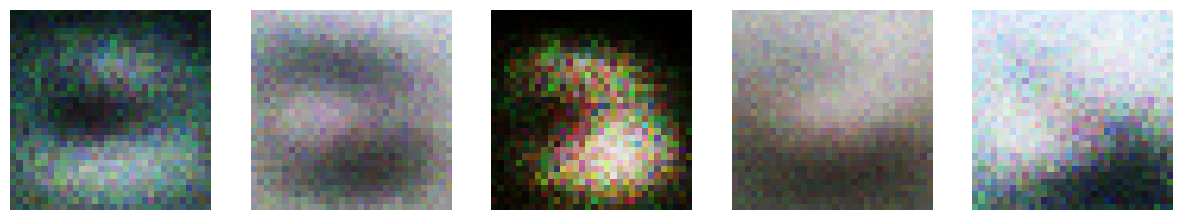

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [10/100], KID: -261909.1875, SWD: 0.4765639975667


Epoch 11/100: 100%|██████████| 391/391 [01:28<00:00,  4.42it/s]


d_loss: 0.7638461589813232, g_loss: 3.4558017253875732


Epoch 12/100: 100%|██████████| 391/391 [01:29<00:00,  4.36it/s]


d_loss: 1.1356348991394043, g_loss: 2.468167304992676


Epoch 13/100: 100%|██████████| 391/391 [01:28<00:00,  4.41it/s]


d_loss: 0.634268581867218, g_loss: 2.9848265647888184


Epoch 14/100: 100%|██████████| 391/391 [01:29<00:00,  4.39it/s]


d_loss: 0.4557531774044037, g_loss: 2.654364585876465


Epoch 15/100: 100%|██████████| 391/391 [01:28<00:00,  4.40it/s]


d_loss: 0.4956907629966736, g_loss: 2.2958996295928955


Epoch 16/100: 100%|██████████| 391/391 [01:28<00:00,  4.41it/s]


d_loss: 0.7248489260673523, g_loss: 2.697434186935425


Epoch 17/100: 100%|██████████| 391/391 [01:28<00:00,  4.43it/s]


d_loss: 0.6503509283065796, g_loss: 2.5054969787597656


Epoch 18/100: 100%|██████████| 391/391 [01:28<00:00,  4.44it/s]


d_loss: 0.5320972204208374, g_loss: 2.2655067443847656


Epoch 19/100: 100%|██████████| 391/391 [01:28<00:00,  4.41it/s]


d_loss: 0.6762651205062866, g_loss: 2.0929336547851562


Epoch 20/100: 100%|██████████| 391/391 [01:28<00:00,  4.43it/s]

d_loss: 0.7740087509155273, g_loss: 1.9146744012832642


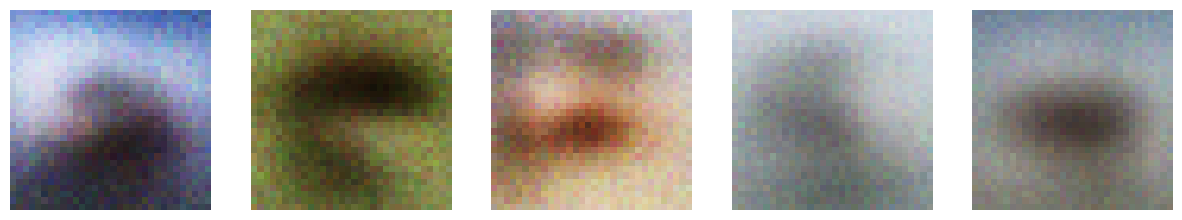

Epoch [20/100], KID: -243052.03125, SWD: 0.45882799848914146


Epoch 21/100: 100%|██████████| 391/391 [01:30<00:00,  4.30it/s]


d_loss: 0.759771466255188, g_loss: 2.1786813735961914


Epoch 22/100: 100%|██████████| 391/391 [01:30<00:00,  4.30it/s]


d_loss: 0.915908932685852, g_loss: 1.7452948093414307


Epoch 23/100: 100%|██████████| 391/391 [01:30<00:00,  4.33it/s]


d_loss: 0.8565285205841064, g_loss: 2.028374195098877


Epoch 24/100: 100%|██████████| 391/391 [01:30<00:00,  4.32it/s]


d_loss: 0.9372140765190125, g_loss: 1.9568252563476562


Epoch 25/100: 100%|██████████| 391/391 [01:29<00:00,  4.38it/s]


d_loss: 0.8622731566429138, g_loss: 1.6679766178131104


Epoch 26/100: 100%|██████████| 391/391 [01:28<00:00,  4.42it/s]


d_loss: 1.1067314147949219, g_loss: 2.0812132358551025


Epoch 27/100: 100%|██████████| 391/391 [01:28<00:00,  4.44it/s]


d_loss: 0.8034335374832153, g_loss: 2.291135787963867


Epoch 28/100: 100%|██████████| 391/391 [01:27<00:00,  4.49it/s]


d_loss: 0.8640575408935547, g_loss: 1.767195224761963


Epoch 29/100: 100%|██████████| 391/391 [01:27<00:00,  4.46it/s]


d_loss: 0.7869013547897339, g_loss: 1.9497780799865723


Epoch 30/100: 100%|██████████| 391/391 [01:26<00:00,  4.51it/s]


d_loss: 1.0246018171310425, g_loss: 1.9783011674880981


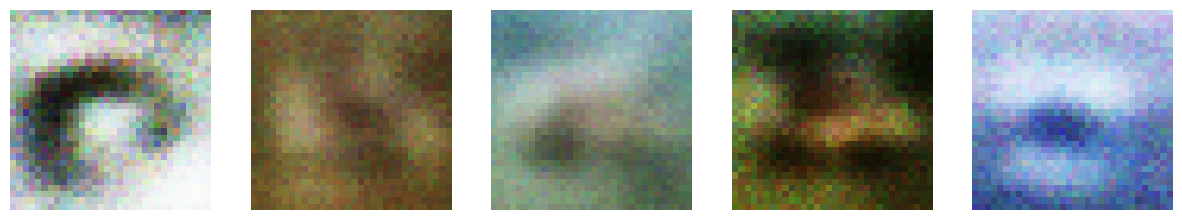

Epoch [30/100], KID: -233388.90625, SWD: 0.4641280025243759


Epoch 31/100: 100%|██████████| 391/391 [01:27<00:00,  4.49it/s]


d_loss: 0.7253075838088989, g_loss: 1.7290196418762207


Epoch 32/100: 100%|██████████| 391/391 [01:28<00:00,  4.39it/s]


d_loss: 0.9619383811950684, g_loss: 1.8212398290634155


Epoch 33/100: 100%|██████████| 391/391 [01:28<00:00,  4.41it/s]


d_loss: 0.8566460609436035, g_loss: 2.0260508060455322


Epoch 34/100: 100%|██████████| 391/391 [01:29<00:00,  4.36it/s]


d_loss: 0.9546124935150146, g_loss: 1.3656508922576904


Epoch 35/100: 100%|██████████| 391/391 [01:28<00:00,  4.41it/s]


d_loss: 1.1901671886444092, g_loss: 2.1070995330810547


Epoch 36/100: 100%|██████████| 391/391 [01:27<00:00,  4.45it/s]


d_loss: 0.8457555174827576, g_loss: 1.6807435750961304


Epoch 37/100: 100%|██████████| 391/391 [01:27<00:00,  4.45it/s]


d_loss: 1.1039704084396362, g_loss: 1.7571500539779663


Epoch 38/100: 100%|██████████| 391/391 [01:28<00:00,  4.42it/s]


d_loss: 0.8992051482200623, g_loss: 1.6652653217315674


Epoch 39/100: 100%|██████████| 391/391 [01:27<00:00,  4.47it/s]


d_loss: 1.0422171354293823, g_loss: 1.6855390071868896


Epoch 40/100: 100%|██████████| 391/391 [01:28<00:00,  4.40it/s]


d_loss: 0.8592233657836914, g_loss: 1.9030035734176636


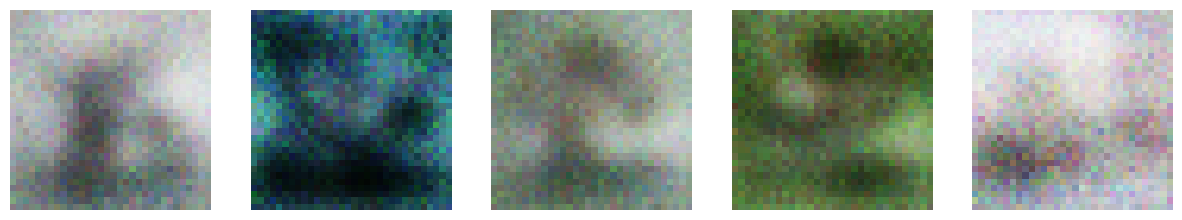

Epoch [40/100], KID: -234958.125, SWD: 0.4689900018274784


Epoch 41/100: 100%|██████████| 391/391 [01:30<00:00,  4.34it/s]


d_loss: 1.0146512985229492, g_loss: 1.681107521057129


Epoch 42/100: 100%|██████████| 391/391 [01:28<00:00,  4.43it/s]


d_loss: 0.8604243993759155, g_loss: 1.9545408487319946


Epoch 43/100: 100%|██████████| 391/391 [01:27<00:00,  4.45it/s]


d_loss: 0.9412208199501038, g_loss: 1.3883624076843262


Epoch 44/100: 100%|██████████| 391/391 [01:28<00:00,  4.42it/s]


d_loss: 0.7918593883514404, g_loss: 1.6672981977462769


Epoch 45/100: 100%|██████████| 391/391 [01:29<00:00,  4.39it/s]


d_loss: 0.9996395111083984, g_loss: 1.5295807123184204


Epoch 46/100: 100%|██████████| 391/391 [01:27<00:00,  4.44it/s]


d_loss: 1.3176077604293823, g_loss: 2.069091320037842


Epoch 47/100: 100%|██████████| 391/391 [01:29<00:00,  4.39it/s]


d_loss: 0.9767285585403442, g_loss: 1.4768768548965454


Epoch 48/100: 100%|██████████| 391/391 [01:30<00:00,  4.33it/s]


d_loss: 1.0487229824066162, g_loss: 1.6197658777236938


Epoch 49/100: 100%|██████████| 391/391 [01:28<00:00,  4.40it/s]


d_loss: 1.070753574371338, g_loss: 1.7221599817276


Epoch 50/100: 100%|██████████| 391/391 [01:28<00:00,  4.41it/s]

d_loss: 1.4941846132278442, g_loss: 3.1134443283081055


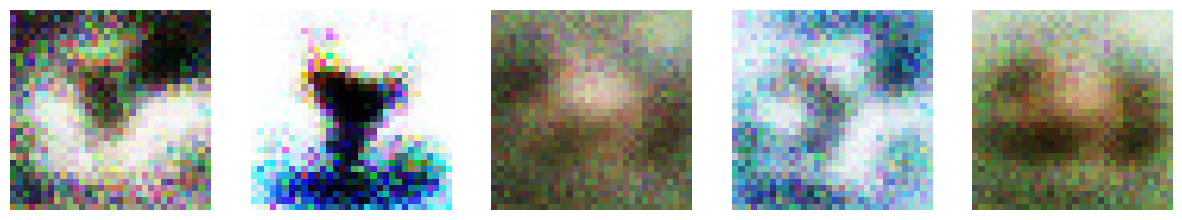

Epoch [50/100], KID: -230151.71875, SWD: 0.4730370007455349


Epoch 51/100: 100%|██████████| 391/391 [01:27<00:00,  4.46it/s]


d_loss: 0.814669668674469, g_loss: 2.154918670654297


Epoch 52/100: 100%|██████████| 391/391 [01:26<00:00,  4.54it/s]


d_loss: 0.918315052986145, g_loss: 1.577493667602539


Epoch 53/100: 100%|██████████| 391/391 [01:26<00:00,  4.53it/s]


d_loss: 0.9822807312011719, g_loss: 1.435669183731079


Epoch 54/100: 100%|██████████| 391/391 [01:26<00:00,  4.51it/s]


d_loss: 1.2976083755493164, g_loss: 1.6144717931747437


Epoch 55/100: 100%|██████████| 391/391 [01:24<00:00,  4.63it/s]


d_loss: 0.819282591342926, g_loss: 1.6617372035980225


Epoch 56/100: 100%|██████████| 391/391 [01:24<00:00,  4.61it/s]


d_loss: 0.9273921251296997, g_loss: 1.3264967203140259


Epoch 57/100: 100%|██████████| 391/391 [01:24<00:00,  4.61it/s]


d_loss: 0.9679924249649048, g_loss: 1.5773389339447021


Epoch 58/100: 100%|██████████| 391/391 [01:24<00:00,  4.61it/s]


d_loss: 0.9691299200057983, g_loss: 1.4397740364074707


Epoch 59/100: 100%|██████████| 391/391 [01:24<00:00,  4.60it/s]


d_loss: 1.087117075920105, g_loss: 1.3971706628799438


Epoch 60/100: 100%|██████████| 391/391 [01:24<00:00,  4.60it/s]

d_loss: 0.9088125228881836, g_loss: 1.7101068496704102


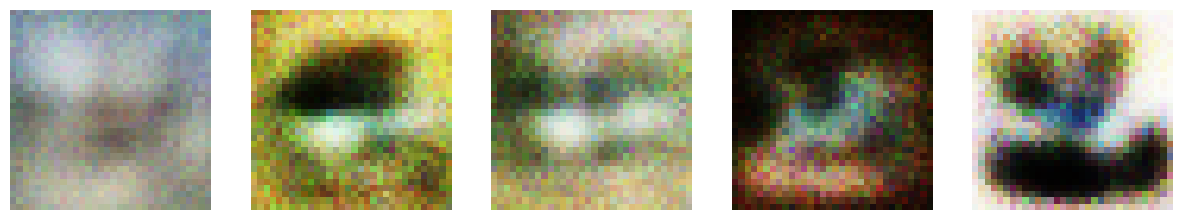

Epoch [60/100], KID: -225308.09375, SWD: 0.46406400576233864


Epoch 61/100: 100%|██████████| 391/391 [01:25<00:00,  4.59it/s]


d_loss: 0.8471487760543823, g_loss: 1.5702390670776367


Epoch 62/100: 100%|██████████| 391/391 [01:25<00:00,  4.57it/s]


d_loss: 0.8856246471405029, g_loss: 1.835425853729248


Epoch 63/100: 100%|██████████| 391/391 [01:25<00:00,  4.55it/s]


d_loss: 1.1020704507827759, g_loss: 1.0970888137817383


Epoch 64/100: 100%|██████████| 391/391 [01:25<00:00,  4.58it/s]


d_loss: 2.0326621532440186, g_loss: 1.4323984384536743


Epoch 65/100: 100%|██████████| 391/391 [01:25<00:00,  4.58it/s]


d_loss: 0.6527350544929504, g_loss: 2.3852102756500244


Epoch 66/100: 100%|██████████| 391/391 [01:25<00:00,  4.59it/s]


d_loss: 1.1468899250030518, g_loss: 1.192435622215271


Epoch 67/100: 100%|██████████| 391/391 [01:25<00:00,  4.59it/s]


d_loss: 1.3110747337341309, g_loss: 1.4787471294403076


Epoch 68/100: 100%|██████████| 391/391 [01:25<00:00,  4.59it/s]


d_loss: 1.0346651077270508, g_loss: 1.4149909019470215


Epoch 69/100: 100%|██████████| 391/391 [01:25<00:00,  4.58it/s]


d_loss: 1.0101910829544067, g_loss: 1.3492043018341064


Epoch 70/100: 100%|██████████| 391/391 [01:25<00:00,  4.58it/s]


d_loss: 1.001448392868042, g_loss: 1.480125904083252


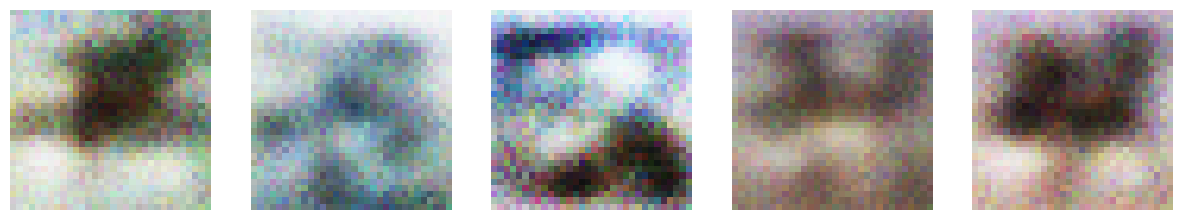

Epoch [70/100], KID: -242767.765625, SWD: 0.4631820023059845


Epoch 71/100: 100%|██████████| 391/391 [01:24<00:00,  4.60it/s]


d_loss: 1.1471081972122192, g_loss: 1.4809969663619995


Epoch 72/100: 100%|██████████| 391/391 [01:24<00:00,  4.62it/s]


d_loss: 1.3319425582885742, g_loss: 0.9340142011642456


Epoch 73/100: 100%|██████████| 391/391 [01:25<00:00,  4.58it/s]


d_loss: 1.0149078369140625, g_loss: 1.9404828548431396


Epoch 74/100: 100%|██████████| 391/391 [01:25<00:00,  4.59it/s]


d_loss: 1.2825809717178345, g_loss: 2.170318603515625


Epoch 75/100: 100%|██████████| 391/391 [01:25<00:00,  4.60it/s]


d_loss: 1.1775195598602295, g_loss: 1.2780060768127441


Epoch 76/100: 100%|██████████| 391/391 [01:25<00:00,  4.59it/s]


d_loss: 1.0813045501708984, g_loss: 1.4170892238616943


Epoch 77/100: 100%|██████████| 391/391 [01:24<00:00,  4.60it/s]


d_loss: 1.095233678817749, g_loss: 1.300342082977295


Epoch 78/100: 100%|██████████| 391/391 [01:25<00:00,  4.60it/s]


d_loss: 0.955345869064331, g_loss: 1.3609647750854492


Epoch 79/100: 100%|██████████| 391/391 [01:24<00:00,  4.62it/s]


d_loss: 0.9901748299598694, g_loss: 1.7118598222732544


Epoch 80/100: 100%|██████████| 391/391 [01:25<00:00,  4.60it/s]

d_loss: 1.0290918350219727, g_loss: 1.5638387203216553


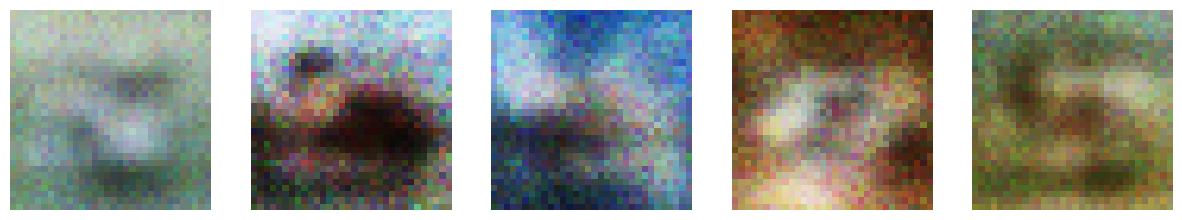

Epoch [80/100], KID: -226362.296875, SWD: 0.47647199407219887


Epoch 81/100: 100%|██████████| 391/391 [01:25<00:00,  4.55it/s]


d_loss: 1.2062382698059082, g_loss: 1.2995777130126953


Epoch 82/100: 100%|██████████| 391/391 [01:25<00:00,  4.57it/s]


d_loss: 1.1085569858551025, g_loss: 1.5683943033218384


Epoch 83/100: 100%|██████████| 391/391 [01:25<00:00,  4.56it/s]


d_loss: 1.2428058385849, g_loss: 1.5355952978134155


Epoch 84/100: 100%|██████████| 391/391 [01:25<00:00,  4.56it/s]


d_loss: 0.990286648273468, g_loss: 1.3612120151519775


Epoch 85/100: 100%|██████████| 391/391 [01:25<00:00,  4.56it/s]


d_loss: 0.9781889915466309, g_loss: 1.666393756866455


Epoch 86/100: 100%|██████████| 391/391 [01:25<00:00,  4.58it/s]


d_loss: 1.1612253189086914, g_loss: 1.6003046035766602


Epoch 87/100: 100%|██████████| 391/391 [01:26<00:00,  4.53it/s]


d_loss: 0.9937171936035156, g_loss: 1.6625921726226807


Epoch 88/100: 100%|██████████| 391/391 [01:26<00:00,  4.54it/s]


d_loss: 1.0935440063476562, g_loss: 1.5262515544891357


Epoch 89/100: 100%|██████████| 391/391 [01:25<00:00,  4.56it/s]


d_loss: 1.5351098775863647, g_loss: 1.2605677843093872


Epoch 90/100: 100%|██████████| 391/391 [01:25<00:00,  4.57it/s]


d_loss: 1.3093171119689941, g_loss: 1.7847956418991089


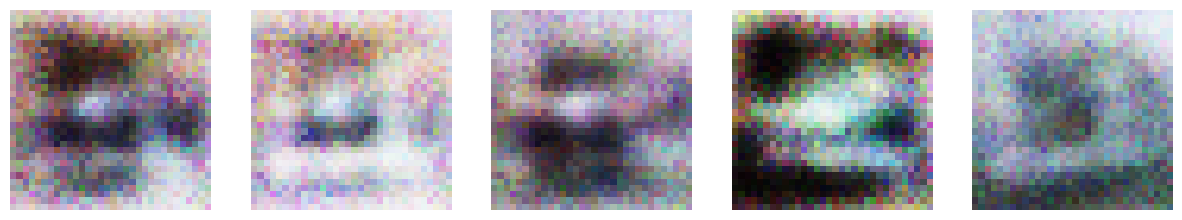

Epoch [90/100], KID: -233057.734375, SWD: 0.4748770035803318


Epoch 91/100: 100%|██████████| 391/391 [01:25<00:00,  4.57it/s]


d_loss: 0.9132475256919861, g_loss: 1.515076756477356


Epoch 92/100: 100%|██████████| 391/391 [01:26<00:00,  4.53it/s]


d_loss: 1.1853913068771362, g_loss: 1.0877354145050049


Epoch 93/100: 100%|██████████| 391/391 [01:27<00:00,  4.48it/s]


d_loss: 0.8012375831604004, g_loss: 1.6329525709152222


Epoch 94/100: 100%|██████████| 391/391 [01:26<00:00,  4.50it/s]


d_loss: 1.0622398853302002, g_loss: 1.5259994268417358


Epoch 95/100: 100%|██████████| 391/391 [01:26<00:00,  4.51it/s]


d_loss: 0.5970674753189087, g_loss: 3.5976998805999756


Epoch 96/100: 100%|██████████| 391/391 [01:26<00:00,  4.54it/s]


d_loss: 0.9048792123794556, g_loss: 1.9042696952819824


Epoch 97/100: 100%|██████████| 391/391 [01:25<00:00,  4.58it/s]


d_loss: 0.9801337122917175, g_loss: 2.1154210567474365


Epoch 98/100: 100%|██████████| 391/391 [01:25<00:00,  4.57it/s]


d_loss: 1.0569192171096802, g_loss: 1.3735551834106445


Epoch 99/100: 100%|██████████| 391/391 [01:25<00:00,  4.57it/s]


d_loss: 0.9856481552124023, g_loss: 1.5976603031158447


Epoch 100/100: 100%|██████████| 391/391 [01:25<00:00,  4.59it/s]


d_loss: 1.1926839351654053, g_loss: 1.4116941690444946


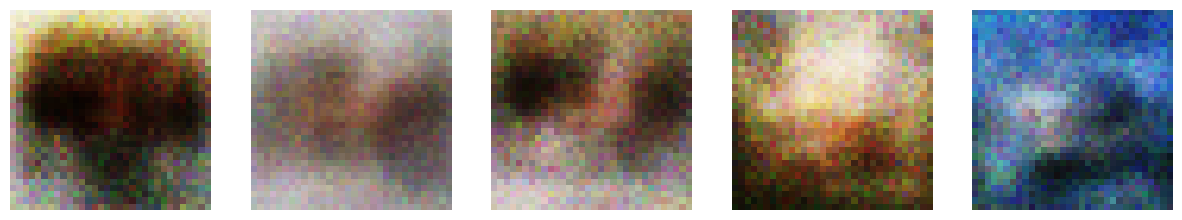

Epoch [100/100], KID: -229002.65625, SWD: 0.47407499700784683


In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 定义模型超参数
latent_dim = 64
hidden_dim = 256
image_dim = 32*32*3  # CIFAR-10 images are 32x32 and colored
num_epochs = 100
batch_size = 128
learning_rate = 0.0002

# 加载数据集
transform = Compose([
    ToTensor(),
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_data = datasets.CIFAR10(
    root='.',
    train=True,
    download=True,
    transform=transform
)

test_data = datasets.CIFAR10(
    root='.',
    train=False,
    download=True,
    transform=transform
)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

# 定义生成器和判别器
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim * 2, hidden_dim * 4),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim * 4, image_dim),
            nn.Tanh(),
        )

    def forward(self, x):
        return self.main(x).view(-1, 3, 32, 32)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(image_dim, hidden_dim * 4),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim * 4, hidden_dim * 2),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.main(x.view(-1, image_dim))

# 初始化模型和优化器
G = Generator().to(device)
D = Discriminator().to(device)

criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=learning_rate)
g_optimizer = torch.optim.Adam(G.parameters(), lr=learning_rate)

def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

kid_scores = []
swd_scores = []

# 训练模型
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
        # 确保最后一批次的尺寸正确
        if images.shape[0] != batch_size:
            continue

        real_images = images.to(device)
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # 训练判别器
        outputs = D(real_images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs

        z = torch.randn(batch_size, latent_dim).to(device)
        fake_images = G(z)
        outputs = D(fake_images.detach())
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs

        d_loss = d_loss_real + d_loss_fake
        reset_grad()
        d_loss.backward()
        d_optimizer.step()

        # 训练生成器
        z = torch.randn(batch_size, latent_dim).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
        g_loss = criterion(outputs, real_labels)

        reset_grad()
        g_loss.backward()
        g_optimizer.step()

    print(f"d_loss: {d_loss.item()}, g_loss: {g_loss.item()}")

    if (epoch + 1) % 10 == 0:
      # 每10个epoch结束后，随机展示5个生成的图像
      z = torch.randn(5, latent_dim).to(device)
      fake_images = G(z)
      fake_images = fake_images.view(-1, 3, 32, 32)
      fake_images = denorm(fake_images)

      fig, ax = plt.subplots(1, 5, figsize=(15, 3))
      for i, img in enumerate(fake_images.detach().cpu().numpy()):
          ax[i].imshow(np.transpose(img, (1, 2, 0)))
          ax[i].axis('off')
      plt.show()

      z = torch.randn(len(test_data), latent_dim).to(device)
      fake_images = G(z)
      fake_images = fake_images.view(-1, 3, 32, 32)
      fake_images = denorm(fake_images)

      # 创建生成的数据集对象
      generated_data = TensorDataset(fake_images, torch.zeros(len(fake_images)))

      # 创建KID和SWD对象并计算指标
      kid_calculator = KID(real_dataset=test_data, generated_dataset=generated_data)
      swd_calculator = SWD(real_dataset=test_data, generated_dataset=generated_data)
      kid_score = kid_calculator.compute_kid()
      swd_score = swd_calculator.compute_swd()

      # 在每个epoch结束后打印KID和SWD指标
      print(f"Epoch [{epoch+1}/{num_epochs}], KID: {kid_score}, SWD: {swd_score}")


## WGAN × CIFAR-10

device =  cuda
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/100: 100%|██████████| 782/782 [00:19<00:00, 39.49it/s]


d_loss: -24.07708740234375, g_loss: 118.29872131347656


Epoch 2/100: 100%|██████████| 782/782 [00:20<00:00, 38.43it/s]


d_loss: -14.579113006591797, g_loss: 8.258149147033691


Epoch 3/100: 100%|██████████| 782/782 [00:20<00:00, 38.43it/s]


d_loss: 3.3503646850585938, g_loss: 43.76588439941406


Epoch 4/100: 100%|██████████| 782/782 [00:20<00:00, 38.07it/s]


d_loss: -9.381668090820312, g_loss: 76.78031921386719


Epoch 5/100: 100%|██████████| 782/782 [00:20<00:00, 38.30it/s]


d_loss: -13.088407516479492, g_loss: 68.86388397216797


Epoch 6/100: 100%|██████████| 782/782 [00:20<00:00, 39.02it/s]


d_loss: -19.523826599121094, g_loss: 57.98238754272461


Epoch 7/100: 100%|██████████| 782/782 [00:20<00:00, 38.91it/s]


d_loss: -11.289551734924316, g_loss: -22.267616271972656


Epoch 8/100: 100%|██████████| 782/782 [00:20<00:00, 38.66it/s]


d_loss: -12.980234146118164, g_loss: -51.568359375


Epoch 9/100: 100%|██████████| 782/782 [00:20<00:00, 38.42it/s]


d_loss: -0.7701930999755859, g_loss: -28.9879150390625


Epoch 10/100: 100%|██████████| 782/782 [00:20<00:00, 38.40it/s]


d_loss: -3.935275077819824, g_loss: -16.112668991088867


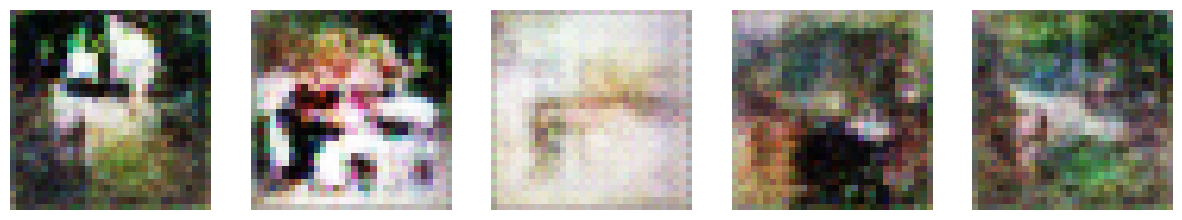

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [10/100], KID: -212017.078125, SWD: 0.4238244965672493


Epoch 11/100: 100%|██████████| 782/782 [00:19<00:00, 39.31it/s]


d_loss: -5.012062072753906, g_loss: 4.486398696899414


Epoch 12/100: 100%|██████████| 782/782 [00:19<00:00, 39.16it/s]


d_loss: 1.2783584594726562, g_loss: -53.31177520751953


Epoch 13/100: 100%|██████████| 782/782 [00:20<00:00, 38.97it/s]


d_loss: -10.296670913696289, g_loss: 43.38713073730469


Epoch 14/100: 100%|██████████| 782/782 [00:19<00:00, 39.30it/s]


d_loss: -17.236888885498047, g_loss: 8.760807037353516


Epoch 15/100: 100%|██████████| 782/782 [00:20<00:00, 39.07it/s]


d_loss: -5.641357421875, g_loss: 10.789156913757324


Epoch 16/100: 100%|██████████| 782/782 [00:19<00:00, 39.23it/s]


d_loss: -1.4491996765136719, g_loss: -52.37444305419922


Epoch 17/100: 100%|██████████| 782/782 [00:19<00:00, 39.14it/s]


d_loss: -6.5585479736328125, g_loss: 69.88871002197266


Epoch 18/100: 100%|██████████| 782/782 [00:19<00:00, 39.19it/s]


d_loss: -16.64310073852539, g_loss: 18.629249572753906


Epoch 19/100: 100%|██████████| 782/782 [00:20<00:00, 38.97it/s]


d_loss: -6.209360122680664, g_loss: -22.349132537841797


Epoch 20/100: 100%|██████████| 782/782 [00:19<00:00, 39.38it/s]


d_loss: -1.544647216796875, g_loss: 25.83993148803711


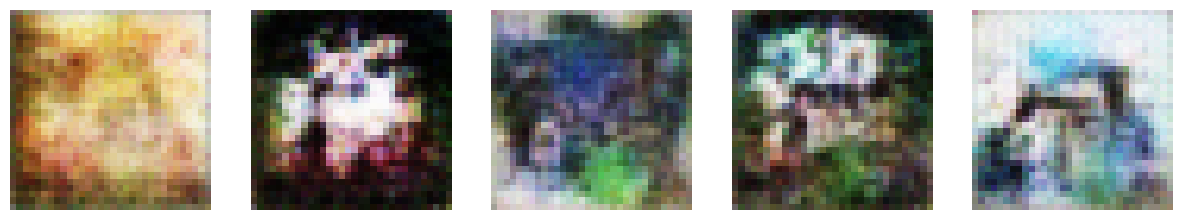

Epoch [20/100], KID: -217641.90625, SWD: 0.43703487142920494


Epoch 21/100: 100%|██████████| 782/782 [00:20<00:00, 38.89it/s]


d_loss: 3.9610023498535156, g_loss: 10.772693634033203


Epoch 22/100: 100%|██████████| 782/782 [00:20<00:00, 38.60it/s]


d_loss: -3.771124839782715, g_loss: 14.561792373657227


Epoch 23/100: 100%|██████████| 782/782 [00:20<00:00, 39.02it/s]


d_loss: -1.4526214599609375, g_loss: 22.00060272216797


Epoch 24/100: 100%|██████████| 782/782 [00:19<00:00, 39.18it/s]


d_loss: -4.133648872375488, g_loss: 13.961807250976562


Epoch 25/100: 100%|██████████| 782/782 [00:19<00:00, 39.15it/s]


d_loss: -1.3723201751708984, g_loss: -1.4066768884658813


Epoch 26/100: 100%|██████████| 782/782 [00:20<00:00, 39.02it/s]


d_loss: -2.017719268798828, g_loss: -3.4088990688323975


Epoch 27/100: 100%|██████████| 782/782 [00:20<00:00, 38.63it/s]


d_loss: -4.249795436859131, g_loss: -11.662504196166992


Epoch 28/100: 100%|██████████| 782/782 [00:20<00:00, 38.49it/s]


d_loss: -2.8520584106445312, g_loss: 15.287910461425781


Epoch 29/100: 100%|██████████| 782/782 [00:20<00:00, 38.69it/s]


d_loss: -0.9218817949295044, g_loss: 17.294164657592773


Epoch 30/100: 100%|██████████| 782/782 [00:20<00:00, 38.92it/s]


d_loss: -5.28656005859375, g_loss: -6.324686050415039


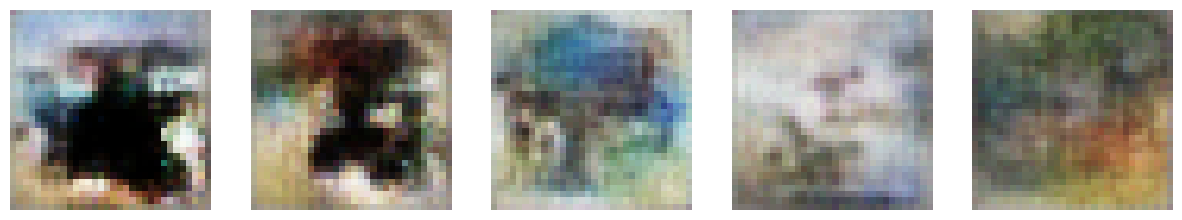

Epoch [30/100], KID: -213987.609375, SWD: 0.4260181225836277


Epoch 31/100: 100%|██████████| 782/782 [00:20<00:00, 38.64it/s]


d_loss: -0.2657299041748047, g_loss: 17.490184783935547


Epoch 32/100: 100%|██████████| 782/782 [00:19<00:00, 39.74it/s]


d_loss: -3.0971717834472656, g_loss: 44.75138854980469


Epoch 33/100: 100%|██████████| 782/782 [00:19<00:00, 39.64it/s]


d_loss: -3.421098470687866, g_loss: 7.008626937866211


Epoch 34/100: 100%|██████████| 782/782 [00:20<00:00, 38.63it/s]


d_loss: 5.797245025634766, g_loss: 17.77078628540039


Epoch 35/100: 100%|██████████| 782/782 [00:20<00:00, 38.49it/s]


d_loss: -6.780291557312012, g_loss: -4.120539665222168


Epoch 36/100: 100%|██████████| 782/782 [00:20<00:00, 37.68it/s]


d_loss: -5.08003044128418, g_loss: 22.11194610595703


Epoch 37/100: 100%|██████████| 782/782 [00:20<00:00, 37.79it/s]


d_loss: -2.9772987365722656, g_loss: -35.193756103515625


Epoch 38/100: 100%|██████████| 782/782 [00:20<00:00, 38.25it/s]


d_loss: -2.602414608001709, g_loss: -0.40882161259651184


Epoch 39/100: 100%|██████████| 782/782 [00:21<00:00, 36.67it/s]


d_loss: -3.0521278381347656, g_loss: 22.0530948638916


Epoch 40/100: 100%|██████████| 782/782 [00:20<00:00, 37.60it/s]


d_loss: -0.7899742126464844, g_loss: 18.56316375732422


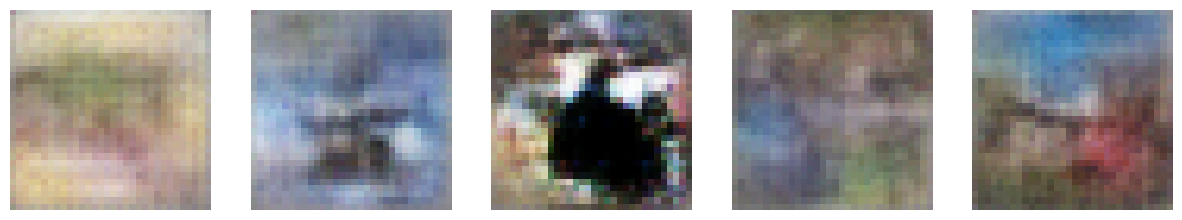

Epoch [40/100], KID: -209839.75, SWD: 0.4070739932358265


Epoch 41/100: 100%|██████████| 782/782 [00:20<00:00, 38.62it/s]


d_loss: -2.6098155975341797, g_loss: 8.533159255981445


Epoch 42/100: 100%|██████████| 782/782 [00:20<00:00, 38.28it/s]


d_loss: -2.876772880554199, g_loss: 10.631095886230469


Epoch 43/100: 100%|██████████| 782/782 [00:20<00:00, 38.40it/s]


d_loss: -2.2375640869140625, g_loss: 32.57600402832031


Epoch 44/100: 100%|██████████| 782/782 [00:20<00:00, 37.98it/s]


d_loss: -4.343518257141113, g_loss: -14.820886611938477


Epoch 45/100: 100%|██████████| 782/782 [00:20<00:00, 37.78it/s]


d_loss: -2.035032272338867, g_loss: 28.81179428100586


Epoch 46/100: 100%|██████████| 782/782 [00:20<00:00, 37.78it/s]


d_loss: 2.5843029022216797, g_loss: 20.56702423095703


Epoch 47/100: 100%|██████████| 782/782 [00:21<00:00, 36.85it/s]


d_loss: -0.557490348815918, g_loss: 7.772818565368652


Epoch 48/100: 100%|██████████| 782/782 [00:21<00:00, 37.16it/s]


d_loss: -1.5150489807128906, g_loss: 0.7970408201217651


Epoch 49/100: 100%|██████████| 782/782 [00:21<00:00, 36.97it/s]


d_loss: -1.0528717041015625, g_loss: 19.988365173339844


Epoch 50/100: 100%|██████████| 782/782 [00:21<00:00, 36.81it/s]


d_loss: -0.7712421417236328, g_loss: 4.479093551635742


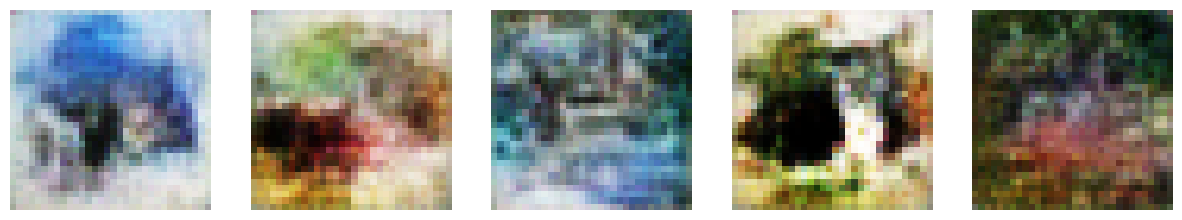

Epoch [50/100], KID: -207170.453125, SWD: 0.4080563746392727


Epoch 51/100: 100%|██████████| 782/782 [00:21<00:00, 36.95it/s]


d_loss: -1.7786099910736084, g_loss: 6.36693000793457


Epoch 52/100: 100%|██████████| 782/782 [00:21<00:00, 36.48it/s]


d_loss: -5.023240089416504, g_loss: 4.868966102600098


Epoch 53/100: 100%|██████████| 782/782 [00:21<00:00, 37.17it/s]


d_loss: -2.6725220680236816, g_loss: -4.53603458404541


Epoch 54/100: 100%|██████████| 782/782 [00:21<00:00, 37.20it/s]


d_loss: -0.8072576522827148, g_loss: 13.196846008300781


Epoch 55/100: 100%|██████████| 782/782 [00:20<00:00, 37.29it/s]


d_loss: -3.0659637451171875, g_loss: -23.53945541381836


Epoch 56/100: 100%|██████████| 782/782 [00:20<00:00, 37.74it/s]


d_loss: -0.9554662704467773, g_loss: 10.898914337158203


Epoch 57/100: 100%|██████████| 782/782 [00:20<00:00, 37.91it/s]


d_loss: -5.234031677246094, g_loss: 45.93746566772461


Epoch 58/100: 100%|██████████| 782/782 [00:20<00:00, 37.56it/s]


d_loss: 0.21313095092773438, g_loss: 4.099210262298584


Epoch 59/100: 100%|██████████| 782/782 [00:21<00:00, 37.14it/s]


d_loss: 0.357715368270874, g_loss: 3.9399397373199463


Epoch 60/100: 100%|██████████| 782/782 [00:20<00:00, 37.47it/s]


d_loss: -1.1665420532226562, g_loss: 6.22245979309082


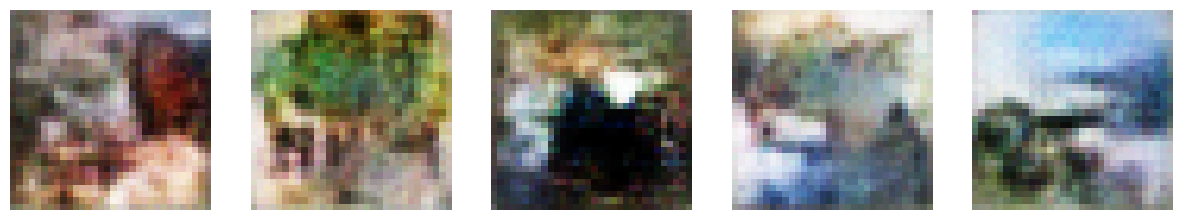

Epoch [60/100], KID: -202645.984375, SWD: 0.3988301195204258


Epoch 61/100: 100%|██████████| 782/782 [00:20<00:00, 38.01it/s]


d_loss: 0.8323783874511719, g_loss: -21.465669631958008


Epoch 62/100: 100%|██████████| 782/782 [00:20<00:00, 38.04it/s]


d_loss: 0.6960849761962891, g_loss: -4.265499114990234


Epoch 63/100: 100%|██████████| 782/782 [00:20<00:00, 38.17it/s]


d_loss: -1.8468198776245117, g_loss: 15.97655200958252


Epoch 64/100: 100%|██████████| 782/782 [00:20<00:00, 37.82it/s]


d_loss: -1.602218747138977, g_loss: -0.5654445886611938


Epoch 65/100: 100%|██████████| 782/782 [00:20<00:00, 37.37it/s]


d_loss: -2.103811740875244, g_loss: -5.834627151489258


Epoch 66/100: 100%|██████████| 782/782 [00:20<00:00, 37.58it/s]


d_loss: -2.5881996154785156, g_loss: 27.710582733154297


Epoch 67/100: 100%|██████████| 782/782 [00:20<00:00, 37.57it/s]


d_loss: 1.6063232421875, g_loss: 11.256052017211914


Epoch 68/100: 100%|██████████| 782/782 [00:20<00:00, 37.28it/s]


d_loss: -1.5535829067230225, g_loss: 3.141407012939453


Epoch 69/100: 100%|██████████| 782/782 [00:20<00:00, 37.66it/s]


d_loss: -2.4641189575195312, g_loss: 11.107084274291992


Epoch 70/100: 100%|██████████| 782/782 [00:20<00:00, 37.50it/s]


d_loss: -1.6647453308105469, g_loss: 16.924705505371094


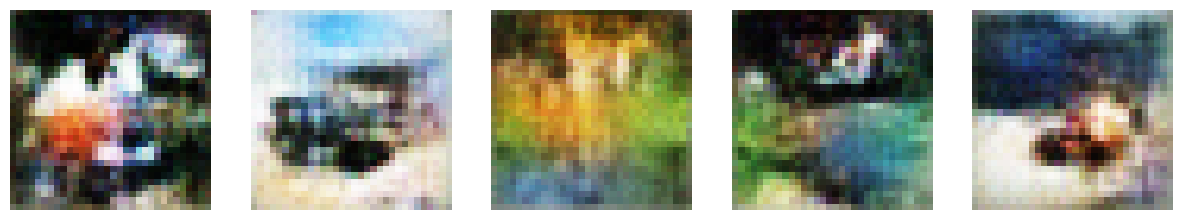

Epoch [70/100], KID: -197610.90625, SWD: 0.381929624825716


Epoch 71/100: 100%|██████████| 782/782 [00:20<00:00, 37.70it/s]


d_loss: -1.2879341840744019, g_loss: 7.148614406585693


Epoch 72/100: 100%|██████████| 782/782 [00:20<00:00, 37.31it/s]


d_loss: 0.7918519973754883, g_loss: 10.304884910583496


Epoch 73/100: 100%|██████████| 782/782 [00:20<00:00, 37.37it/s]


d_loss: -1.602238655090332, g_loss: 6.656421661376953


Epoch 74/100: 100%|██████████| 782/782 [00:20<00:00, 37.97it/s]


d_loss: -2.2927370071411133, g_loss: 20.935821533203125


Epoch 75/100: 100%|██████████| 782/782 [00:20<00:00, 37.64it/s]


d_loss: -1.0667383670806885, g_loss: -3.5592808723449707


Epoch 76/100: 100%|██████████| 782/782 [00:20<00:00, 37.44it/s]


d_loss: -0.46860551834106445, g_loss: 17.09762954711914


Epoch 77/100: 100%|██████████| 782/782 [00:20<00:00, 37.69it/s]


d_loss: -1.098543405532837, g_loss: 8.593412399291992


Epoch 78/100: 100%|██████████| 782/782 [00:20<00:00, 38.07it/s]


d_loss: -0.6105098724365234, g_loss: 11.634638786315918


Epoch 79/100: 100%|██████████| 782/782 [00:20<00:00, 37.77it/s]


d_loss: -0.04639172554016113, g_loss: 0.9828124046325684


Epoch 80/100: 100%|██████████| 782/782 [00:20<00:00, 37.62it/s]


d_loss: 0.9755692481994629, g_loss: -6.564279556274414


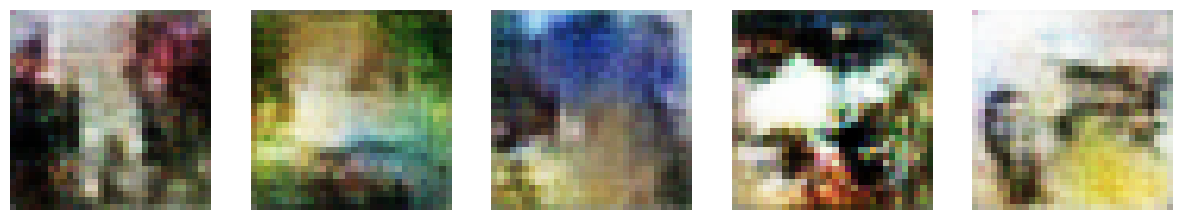

Epoch [80/100], KID: -195157.90625, SWD: 0.3723831810057163


Epoch 81/100: 100%|██████████| 782/782 [00:20<00:00, 37.74it/s]


d_loss: -1.4384856224060059, g_loss: 8.839019775390625


Epoch 82/100: 100%|██████████| 782/782 [00:20<00:00, 37.61it/s]


d_loss: -1.4312481880187988, g_loss: -9.512565612792969


Epoch 83/100: 100%|██████████| 782/782 [00:20<00:00, 37.92it/s]


d_loss: -1.1712591648101807, g_loss: 1.011127233505249


Epoch 84/100: 100%|██████████| 782/782 [00:20<00:00, 37.60it/s]


d_loss: -1.0318384170532227, g_loss: -1.98250150680542


Epoch 85/100: 100%|██████████| 782/782 [00:20<00:00, 38.10it/s]


d_loss: -3.290163040161133, g_loss: 39.42481994628906


Epoch 86/100: 100%|██████████| 782/782 [00:20<00:00, 38.04it/s]


d_loss: -3.3122406005859375, g_loss: 13.788314819335938


Epoch 87/100: 100%|██████████| 782/782 [00:21<00:00, 36.90it/s]


d_loss: -1.2966041564941406, g_loss: 10.489781379699707


Epoch 88/100: 100%|██████████| 782/782 [00:20<00:00, 37.75it/s]


d_loss: -2.1507303714752197, g_loss: -8.327134132385254


Epoch 89/100: 100%|██████████| 782/782 [00:20<00:00, 37.57it/s]


d_loss: -0.6940717697143555, g_loss: 6.618415832519531


Epoch 90/100: 100%|██████████| 782/782 [00:20<00:00, 37.64it/s]


d_loss: -1.9582595825195312, g_loss: 27.85228729248047


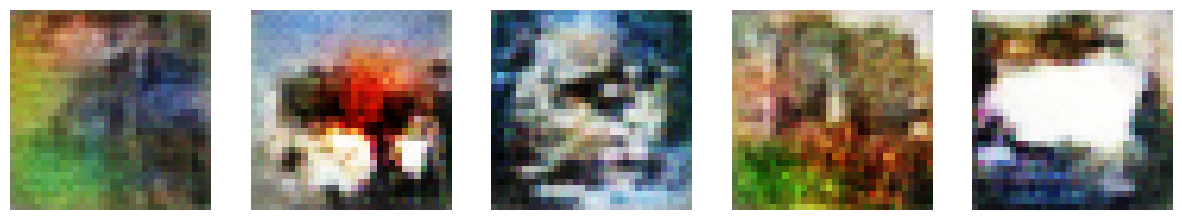

Epoch [90/100], KID: -196195.703125, SWD: 0.37497424706816673


Epoch 91/100: 100%|██████████| 782/782 [00:20<00:00, 37.63it/s]


d_loss: -1.4737820625305176, g_loss: -4.15367317199707


Epoch 92/100: 100%|██████████| 782/782 [00:20<00:00, 37.85it/s]


d_loss: -0.6911392211914062, g_loss: 6.2949676513671875


Epoch 93/100: 100%|██████████| 782/782 [00:20<00:00, 37.69it/s]


d_loss: -1.083550214767456, g_loss: -4.2410502433776855


Epoch 94/100: 100%|██████████| 782/782 [00:21<00:00, 37.07it/s]


d_loss: 0.6737174987792969, g_loss: -8.883148193359375


Epoch 95/100: 100%|██████████| 782/782 [00:20<00:00, 37.83it/s]


d_loss: -0.276578426361084, g_loss: -1.769120693206787


Epoch 96/100: 100%|██████████| 782/782 [00:20<00:00, 37.91it/s]


d_loss: -1.6726112365722656, g_loss: 15.198904037475586


Epoch 97/100: 100%|██████████| 782/782 [00:20<00:00, 37.54it/s]


d_loss: -1.0152931213378906, g_loss: -1.49380624294281


Epoch 98/100: 100%|██████████| 782/782 [00:20<00:00, 37.36it/s]


d_loss: 2.2850990295410156, g_loss: 18.587539672851562


Epoch 99/100: 100%|██████████| 782/782 [00:20<00:00, 37.98it/s]


d_loss: -2.53542423248291, g_loss: 18.64249038696289


Epoch 100/100: 100%|██████████| 782/782 [00:21<00:00, 37.03it/s]


d_loss: -2.8056764602661133, g_loss: -9.198936462402344


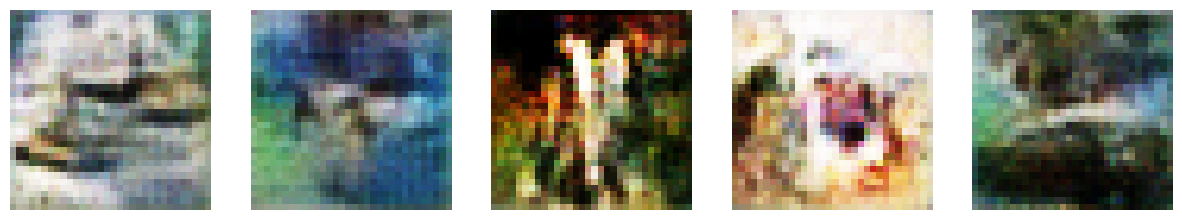

Epoch [100/100], KID: -195936.53125, SWD: 0.36646975204348564


In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('device = ', device)

# 定义模型超参数
latent_dim = 100
num_epochs = 100
batch_size = 64
learning_rate = 0.0002
clip_value = 0.01  # WGAN cliping value

# 加载数据集
transform = Compose([
    ToTensor(),
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_data = datasets.CIFAR10(
    root='.',
    train=True,
    download=True,
    transform=transform
)

test_data = datasets.CIFAR10(
    root='.',
    train=False,
    download=True,
    transform=transform
)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # 输入为100维的随机噪声向量
        self.fc = nn.Linear(100, 512*2*2) # 输出为512x2x2
        self.deconv1 = nn.ConvTranspose2d(512, 256, 4, 2, 1) # 输出为256x4x4
        self.deconv2 = nn.ConvTranspose2d(256, 128, 4, 2, 1) # 输出为128x8x8
        self.deconv3 = nn.ConvTranspose2d(128, 64, 4, 2, 1) # 输出为64x16x16
        self.deconv4 = nn.ConvTranspose2d(64, 3, 4, 2, 1) # 输出为3x32x32
        self.bn1 = nn.BatchNorm2d(256)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, z):
        z = self.fc(z)
        z = z.view(-1, 512, 2 ,2)
        z = self.relu(self.bn1(self.deconv1(z)))
        z = self.relu(self.bn2(self.deconv2(z)))
        z = self.relu(self.bn3(self.deconv3(z)))
        z = self.tanh(self.deconv4(z))
        return z

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # 输入为3x32x32的CIFAR-10图像
        self.conv1 = nn.Conv2d(3, 64, 4, 2, 1) # 输出为64x16x16
        self.conv2 = nn.Conv2d(64, 128, 4, 2, 1) # 输出为128x8x8
        self.conv3 = nn.Conv2d(128, 256, 4, 2, 1) # 输出为256x4x4
        self.conv4 = nn.Conv2d(256, 512, 4, 2, 1) # 输出为512x2x2
        self.fc = nn.Linear(512*2*2, 1) # 输出为1
        self.lrelu = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = self.lrelu(self.conv1(x))
        x = self.lrelu(self.conv2(x))
        x = self.lrelu(self.conv3(x))
        x = self.lrelu(self.conv4(x))
        x = x.view(-1, 512*2*2)
        x = self.fc(x)
        return x

# 初始化模型和优化器
G = Generator().to(device)
D = Discriminator().to(device)

d_optimizer = torch.optim.RMSprop(D.parameters(), lr=learning_rate)
g_optimizer = torch.optim.RMSprop(G.parameters(), lr=learning_rate)

def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

# 训练模型
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
        # 确保最后一批次的尺寸正确
        if images.shape[0] != batch_size:
            continue

        real_images = images.to(device)

        # 训练判别器
        z = torch.randn(batch_size, latent_dim).to(device)
        fake_images = G(z)
        
        real_outputs = D(real_images)
        fake_outputs = D(fake_images.detach())

        d_loss = -torch.mean(real_outputs) + torch.mean(fake_outputs)
        reset_grad()
        d_loss.backward()
        d_optimizer.step()

        # Clip weights of discriminator
        for p in D.parameters():
            p.data.clamp_(-clip_value, clip_value)

        # 训练生成器
        if i % 5 == 0:
            z = torch.randn(batch_size, latent_dim).to(device)
            fake_images = G(z)
            outputs = D(fake_images)
            g_loss = -torch.mean(outputs)

            reset_grad()
            g_loss.backward()
            g_optimizer.step()

    print(f"d_loss: {d_loss.item()}, g_loss: {g_loss.item()}")

    if (epoch + 1) % 10 == 0:
        # 每5个epoch结束后，随机展示5个生成的图像
        z = torch.randn(5, latent_dim).to(device)
        fake_images = G(z)
        fake_images = fake_images.view(-1, 3, 32, 32)
        fake_images = denorm(fake_images)

        fig, ax = plt.subplots(1, 5, figsize=(15, 3))
        for i, img in enumerate(fake_images.detach().cpu().numpy()):
            ax[i].imshow(np.transpose(img, (1, 2, 0)))
            ax[i].axis('off')
        plt.show()
        plt.savefig(f'WGAN_[{epoch}].png')

        z = torch.randn(len(test_data), latent_dim).to(device)
        fake_images = G(z)
        fake_images = fake_images.view(-1, 3, 32, 32)
        fake_images = denorm(fake_images)

        # 创建生成的数据集对象
        generated_data = TensorDataset(fake_images.detach().cpu(), torch.zeros(len(fake_images)))

        # 创建KID和SWD对象并计算指标
        kid_calculator = KID(real_dataset=test_data, generated_dataset=generated_data)
        swd_calculator = SWD(real_dataset=test_data, generated_dataset=generated_data)
        kid_score = kid_calculator.compute_kid()
        swd_score = swd_calculator.compute_swd()

        # 在每个epoch结束后打印KID和SWD指标
        print(f"Epoch [{epoch+1}/{num_epochs}], KID: {kid_score}, SWD: {swd_score}")


## WGAN-GP × CIFAR-10

device =  cuda


100%|██████████| 170498071/170498071 [00:05<00:00, 28734374.55it/s]


Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


Epoch 1/100: 100%|██████████| 782/782 [00:37<00:00, 20.65it/s]


d_loss: -7.313629627227783, g_loss: -8.254709243774414


Epoch 2/100: 100%|██████████| 782/782 [00:30<00:00, 25.38it/s]


d_loss: -5.095424175262451, g_loss: -17.753215789794922


Epoch 3/100: 100%|██████████| 782/782 [00:31<00:00, 24.52it/s]


d_loss: -4.317710876464844, g_loss: -13.661276817321777


Epoch 4/100: 100%|██████████| 782/782 [00:32<00:00, 23.98it/s]


d_loss: -4.406040668487549, g_loss: -14.847909927368164


Epoch 5/100: 100%|██████████| 782/782 [00:32<00:00, 24.36it/s]


d_loss: -3.3736069202423096, g_loss: -12.313688278198242


Epoch 6/100: 100%|██████████| 782/782 [00:32<00:00, 24.36it/s]


d_loss: -3.5938658714294434, g_loss: -7.413787841796875


Epoch 7/100: 100%|██████████| 782/782 [00:32<00:00, 24.29it/s]


d_loss: -2.755034923553467, g_loss: -6.112449645996094


Epoch 8/100: 100%|██████████| 782/782 [00:32<00:00, 24.37it/s]


d_loss: -3.196542978286743, g_loss: -7.336637496948242


Epoch 9/100: 100%|██████████| 782/782 [00:32<00:00, 24.36it/s]


d_loss: -3.319417953491211, g_loss: -8.46725845336914


Epoch 10/100: 100%|██████████| 782/782 [00:32<00:00, 24.32it/s]


d_loss: -2.717893123626709, g_loss: -5.547310829162598


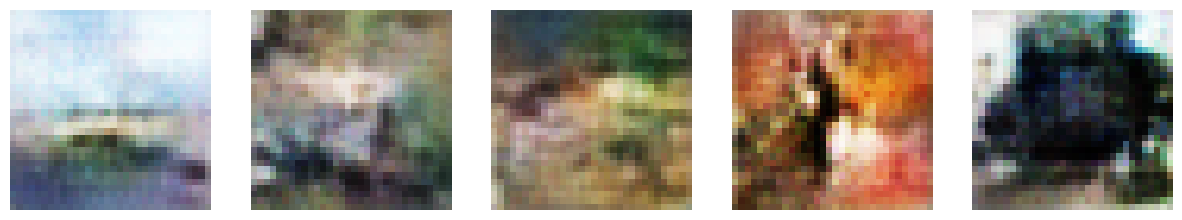

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 276MB/s]


Epoch [10/100], KID: -195541.09375, SWD: 0.38206349685788155


Epoch 11/100: 100%|██████████| 782/782 [00:32<00:00, 24.10it/s]


d_loss: -2.456718683242798, g_loss: -4.785353183746338


Epoch 12/100: 100%|██████████| 782/782 [00:32<00:00, 24.29it/s]


d_loss: -2.475616455078125, g_loss: -5.5294623374938965


Epoch 13/100: 100%|██████████| 782/782 [00:32<00:00, 24.33it/s]


d_loss: -2.8680453300476074, g_loss: -7.347038269042969


Epoch 14/100: 100%|██████████| 782/782 [00:32<00:00, 24.29it/s]


d_loss: -2.2622623443603516, g_loss: -4.956660270690918


Epoch 15/100: 100%|██████████| 782/782 [00:32<00:00, 24.37it/s]


d_loss: -2.585556983947754, g_loss: -3.7591066360473633


Epoch 16/100: 100%|██████████| 782/782 [00:32<00:00, 24.36it/s]


d_loss: -2.582052707672119, g_loss: -4.310804843902588


Epoch 17/100: 100%|██████████| 782/782 [00:32<00:00, 24.35it/s]


d_loss: -2.546208143234253, g_loss: -4.109109401702881


Epoch 18/100: 100%|██████████| 782/782 [00:32<00:00, 24.18it/s]


d_loss: -2.8810620307922363, g_loss: -1.4648406505584717


Epoch 19/100: 100%|██████████| 782/782 [00:32<00:00, 24.23it/s]


d_loss: -2.567539930343628, g_loss: -6.762152194976807


Epoch 20/100: 100%|██████████| 782/782 [00:32<00:00, 24.26it/s]


d_loss: -2.230656623840332, g_loss: -3.9357757568359375


<Figure size 640x480 with 0 Axes>

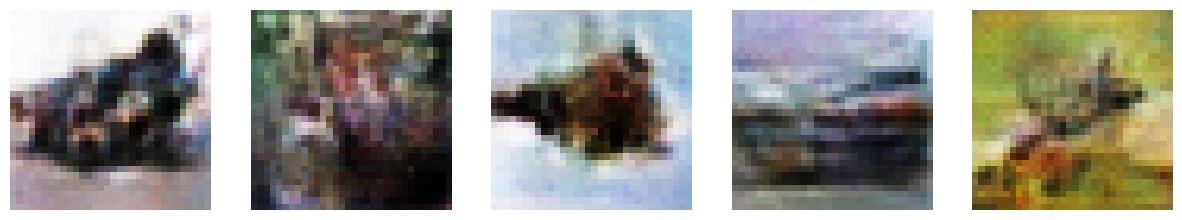

Epoch [20/100], KID: -170658.0, SWD: 0.30665937438607216


Epoch 21/100: 100%|██████████| 782/782 [00:32<00:00, 24.18it/s]


d_loss: -2.1599504947662354, g_loss: -3.6592376232147217


Epoch 22/100: 100%|██████████| 782/782 [00:31<00:00, 24.46it/s]


d_loss: -2.5105960369110107, g_loss: -3.84710693359375


Epoch 23/100: 100%|██████████| 782/782 [00:31<00:00, 24.51it/s]


d_loss: -2.306647539138794, g_loss: -5.237987041473389


Epoch 24/100: 100%|██████████| 782/782 [00:32<00:00, 24.39it/s]


d_loss: -2.456491231918335, g_loss: -2.6108522415161133


Epoch 25/100: 100%|██████████| 782/782 [00:32<00:00, 24.44it/s]


d_loss: -3.0426506996154785, g_loss: -4.179892539978027


Epoch 26/100: 100%|██████████| 782/782 [00:32<00:00, 24.39it/s]


d_loss: -2.2903339862823486, g_loss: -1.7206330299377441


Epoch 27/100: 100%|██████████| 782/782 [00:32<00:00, 24.41it/s]


d_loss: -2.1556997299194336, g_loss: -6.966751575469971


Epoch 28/100: 100%|██████████| 782/782 [00:32<00:00, 24.38it/s]


d_loss: -2.3695576190948486, g_loss: -4.8571014404296875


Epoch 29/100: 100%|██████████| 782/782 [00:31<00:00, 24.44it/s]


d_loss: -2.055274248123169, g_loss: -5.8295087814331055


Epoch 30/100: 100%|██████████| 782/782 [00:32<00:00, 24.40it/s]


d_loss: -1.6886948347091675, g_loss: -2.898258924484253


<Figure size 640x480 with 0 Axes>

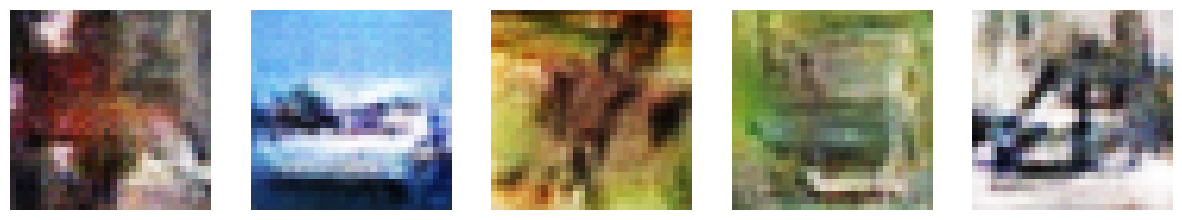

Epoch [30/100], KID: -162655.484375, SWD: 0.2847452498972416


Epoch 31/100: 100%|██████████| 782/782 [00:32<00:00, 24.21it/s]


d_loss: -2.0580945014953613, g_loss: -4.349860668182373


Epoch 32/100: 100%|██████████| 782/782 [00:32<00:00, 24.38it/s]


d_loss: -2.0907254219055176, g_loss: -4.531850814819336


Epoch 33/100: 100%|██████████| 782/782 [00:32<00:00, 24.30it/s]


d_loss: -1.671995997428894, g_loss: -4.386022090911865


Epoch 34/100: 100%|██████████| 782/782 [00:32<00:00, 24.31it/s]


d_loss: -2.4745123386383057, g_loss: -4.128783226013184


Epoch 35/100: 100%|██████████| 782/782 [00:32<00:00, 24.40it/s]


d_loss: -2.3771443367004395, g_loss: -5.747941017150879


Epoch 36/100: 100%|██████████| 782/782 [00:32<00:00, 24.43it/s]


d_loss: -1.9496073722839355, g_loss: -4.147126197814941


Epoch 37/100: 100%|██████████| 782/782 [00:31<00:00, 24.45it/s]


d_loss: -1.9980885982513428, g_loss: -2.373304843902588


Epoch 38/100: 100%|██████████| 782/782 [00:32<00:00, 24.41it/s]


d_loss: -2.4617068767547607, g_loss: -6.096629619598389


Epoch 39/100: 100%|██████████| 782/782 [00:32<00:00, 24.29it/s]


d_loss: -2.339064836502075, g_loss: -3.499077081680298


Epoch 40/100: 100%|██████████| 782/782 [00:32<00:00, 24.36it/s]


d_loss: -1.7424689531326294, g_loss: -2.9831666946411133


<Figure size 640x480 with 0 Axes>

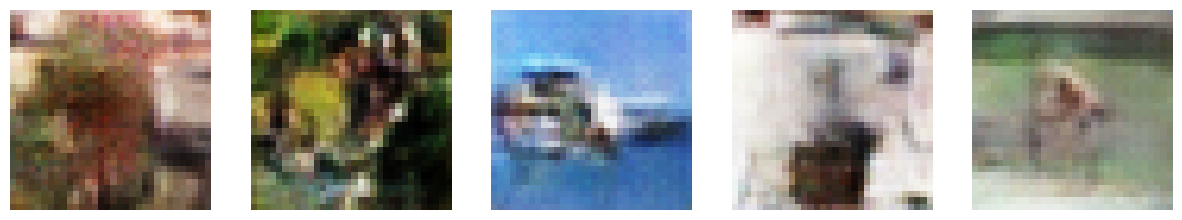

Epoch [40/100], KID: -162180.5, SWD: 0.2677129991352558


Epoch 41/100: 100%|██████████| 782/782 [00:32<00:00, 24.24it/s]


d_loss: -2.0094006061553955, g_loss: -4.537347793579102


Epoch 42/100: 100%|██████████| 782/782 [00:32<00:00, 24.40it/s]


d_loss: -1.95195472240448, g_loss: -4.1585845947265625


Epoch 43/100: 100%|██████████| 782/782 [00:31<00:00, 24.47it/s]


d_loss: -1.7371681928634644, g_loss: -6.082522869110107


Epoch 44/100: 100%|██████████| 782/782 [00:32<00:00, 24.38it/s]


d_loss: -1.713438868522644, g_loss: -3.9096882343292236


Epoch 45/100: 100%|██████████| 782/782 [00:31<00:00, 24.46it/s]


d_loss: -2.459926128387451, g_loss: -5.391787528991699


Epoch 46/100: 100%|██████████| 782/782 [00:32<00:00, 24.40it/s]


d_loss: -2.0026676654815674, g_loss: -2.21805739402771


Epoch 47/100: 100%|██████████| 782/782 [00:32<00:00, 24.18it/s]


d_loss: -2.553922176361084, g_loss: -4.460906982421875


Epoch 48/100: 100%|██████████| 782/782 [00:32<00:00, 24.30it/s]


d_loss: -1.8924647569656372, g_loss: -3.612908363342285


Epoch 49/100: 100%|██████████| 782/782 [00:32<00:00, 24.34it/s]


d_loss: -1.7075529098510742, g_loss: -1.683955430984497


Epoch 50/100: 100%|██████████| 782/782 [00:32<00:00, 24.34it/s]


d_loss: -2.2992615699768066, g_loss: -6.96367073059082


<Figure size 640x480 with 0 Axes>

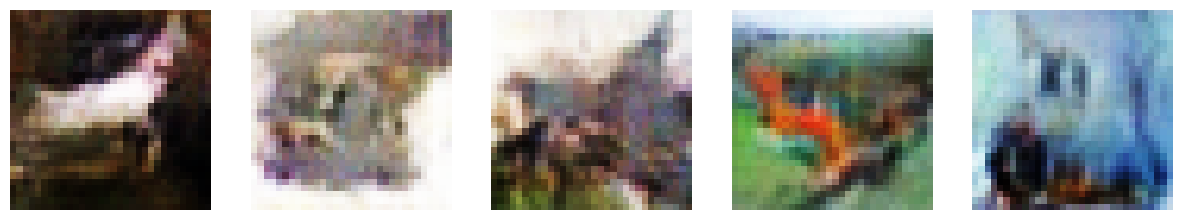

Epoch [50/100], KID: -155936.65625, SWD: 0.24924775026738644


Epoch 51/100: 100%|██████████| 782/782 [00:32<00:00, 24.21it/s]


d_loss: -2.118891477584839, g_loss: -2.4958553314208984


Epoch 52/100: 100%|██████████| 782/782 [00:32<00:00, 24.41it/s]


d_loss: -1.5375425815582275, g_loss: -5.231878757476807


Epoch 53/100: 100%|██████████| 782/782 [00:32<00:00, 24.39it/s]


d_loss: -2.1716196537017822, g_loss: -4.515531539916992


Epoch 54/100: 100%|██████████| 782/782 [00:32<00:00, 24.24it/s]


d_loss: -2.471654176712036, g_loss: -1.5494319200515747


Epoch 55/100: 100%|██████████| 782/782 [00:32<00:00, 24.26it/s]


d_loss: -1.3862841129302979, g_loss: -4.272928237915039


Epoch 56/100: 100%|██████████| 782/782 [00:32<00:00, 24.31it/s]


d_loss: -2.1883082389831543, g_loss: -5.59738302230835


Epoch 57/100: 100%|██████████| 782/782 [00:32<00:00, 24.29it/s]


d_loss: -1.5808628797531128, g_loss: -3.79565691947937


Epoch 58/100: 100%|██████████| 782/782 [00:32<00:00, 24.29it/s]


d_loss: -1.8005460500717163, g_loss: -3.7554097175598145


Epoch 59/100: 100%|██████████| 782/782 [00:32<00:00, 24.32it/s]


d_loss: -2.2346138954162598, g_loss: -1.6638903617858887


Epoch 60/100: 100%|██████████| 782/782 [00:32<00:00, 24.30it/s]


d_loss: -2.3836920261383057, g_loss: -3.5737686157226562


<Figure size 640x480 with 0 Axes>

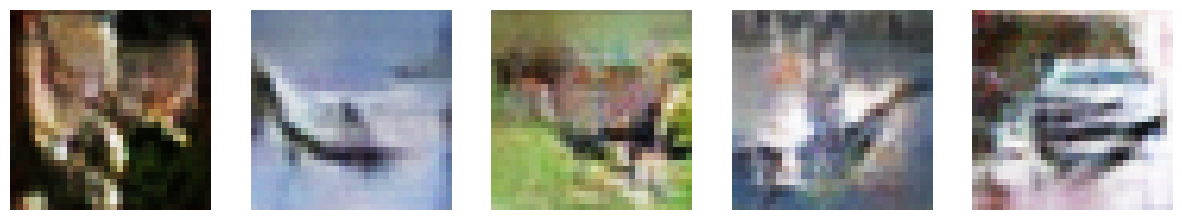

Epoch [60/100], KID: -156180.96875, SWD: 0.24213387444615364


Epoch 61/100: 100%|██████████| 782/782 [00:32<00:00, 24.23it/s]


d_loss: -2.3096771240234375, g_loss: 0.7348054647445679


Epoch 62/100: 100%|██████████| 782/782 [00:32<00:00, 24.40it/s]


d_loss: -1.8242172002792358, g_loss: -3.923438549041748


Epoch 63/100: 100%|██████████| 782/782 [00:31<00:00, 24.47it/s]


d_loss: -2.0733489990234375, g_loss: -4.483217239379883


Epoch 64/100: 100%|██████████| 782/782 [00:32<00:00, 24.33it/s]


d_loss: -1.8601634502410889, g_loss: -2.873950719833374


Epoch 65/100: 100%|██████████| 782/782 [00:32<00:00, 24.41it/s]


d_loss: -1.8909156322479248, g_loss: -2.0337483882904053


Epoch 66/100: 100%|██████████| 782/782 [00:31<00:00, 24.44it/s]


d_loss: -1.5823490619659424, g_loss: -3.4039053916931152


Epoch 67/100: 100%|██████████| 782/782 [00:32<00:00, 24.32it/s]


d_loss: -2.2782161235809326, g_loss: -1.8648401498794556


Epoch 68/100: 100%|██████████| 782/782 [00:32<00:00, 24.38it/s]


d_loss: -1.8383508920669556, g_loss: -4.394926071166992


Epoch 69/100: 100%|██████████| 782/782 [00:32<00:00, 24.37it/s]


d_loss: -1.8747730255126953, g_loss: -5.430274486541748


Epoch 70/100: 100%|██████████| 782/782 [00:32<00:00, 24.37it/s]


d_loss: -1.7363005876541138, g_loss: -0.4646386206150055


<Figure size 640x480 with 0 Axes>

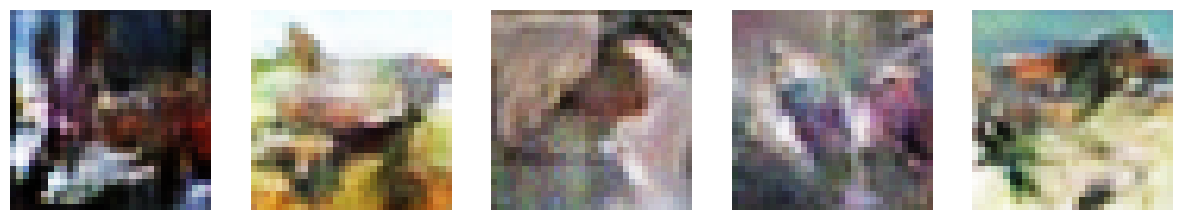

Epoch [70/100], KID: -156169.75, SWD: 0.2515120003372431


Epoch 71/100: 100%|██████████| 782/782 [00:32<00:00, 24.25it/s]


d_loss: -1.6622447967529297, g_loss: -1.8933182954788208


Epoch 72/100: 100%|██████████| 782/782 [00:32<00:00, 24.42it/s]


d_loss: -1.3441706895828247, g_loss: -3.5042407512664795


Epoch 73/100: 100%|██████████| 782/782 [00:32<00:00, 24.38it/s]


d_loss: -1.8695735931396484, g_loss: -3.977975368499756


Epoch 74/100: 100%|██████████| 782/782 [00:32<00:00, 24.32it/s]


d_loss: -1.4000245332717896, g_loss: -1.6595220565795898


Epoch 75/100: 100%|██████████| 782/782 [00:32<00:00, 24.35it/s]


d_loss: -1.9946012496948242, g_loss: -3.9504783153533936


Epoch 76/100: 100%|██████████| 782/782 [00:32<00:00, 24.38it/s]


d_loss: -2.159308433532715, g_loss: -3.2386648654937744


Epoch 77/100: 100%|██████████| 782/782 [00:31<00:00, 24.44it/s]


d_loss: -1.741066813468933, g_loss: 0.6772680282592773


Epoch 78/100: 100%|██████████| 782/782 [00:32<00:00, 24.35it/s]


d_loss: -1.9694136381149292, g_loss: -2.288969039916992


Epoch 79/100: 100%|██████████| 782/782 [00:32<00:00, 24.30it/s]


d_loss: -1.8804973363876343, g_loss: -2.7800822257995605


Epoch 80/100: 100%|██████████| 782/782 [00:32<00:00, 24.33it/s]


d_loss: -1.7420260906219482, g_loss: -3.442412853240967


<Figure size 640x480 with 0 Axes>

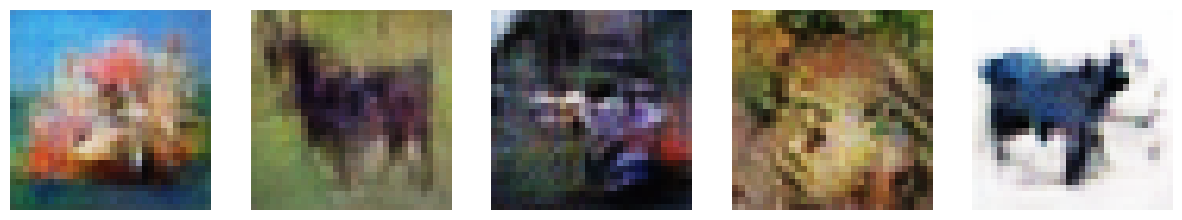

Epoch [80/100], KID: -152013.015625, SWD: 0.2459264975041151


Epoch 81/100: 100%|██████████| 782/782 [00:32<00:00, 24.14it/s]


d_loss: -1.6817402839660645, g_loss: -1.5948758125305176


Epoch 82/100: 100%|██████████| 782/782 [00:32<00:00, 24.41it/s]


d_loss: -1.8630884885787964, g_loss: 0.010146386921405792


Epoch 83/100: 100%|██████████| 782/782 [00:32<00:00, 24.40it/s]


d_loss: -1.6970784664154053, g_loss: -3.715395212173462


Epoch 84/100: 100%|██████████| 782/782 [00:32<00:00, 24.31it/s]


d_loss: -1.7652978897094727, g_loss: -2.3542394638061523


Epoch 85/100: 100%|██████████| 782/782 [00:32<00:00, 24.37it/s]


d_loss: -2.072636842727661, g_loss: -2.5261731147766113


Epoch 86/100: 100%|██████████| 782/782 [00:32<00:00, 24.43it/s]


d_loss: -1.706852674484253, g_loss: -2.7272496223449707


Epoch 87/100: 100%|██████████| 782/782 [00:32<00:00, 24.42it/s]


d_loss: -1.9617894887924194, g_loss: -2.0437769889831543


Epoch 88/100: 100%|██████████| 782/782 [00:32<00:00, 24.41it/s]


d_loss: -1.686407208442688, g_loss: -2.2684414386749268


Epoch 89/100: 100%|██████████| 782/782 [00:32<00:00, 24.41it/s]


d_loss: -2.009542465209961, g_loss: -2.6634154319763184


Epoch 90/100: 100%|██████████| 782/782 [00:32<00:00, 24.31it/s]


d_loss: -1.8102957010269165, g_loss: -3.066084861755371


<Figure size 640x480 with 0 Axes>

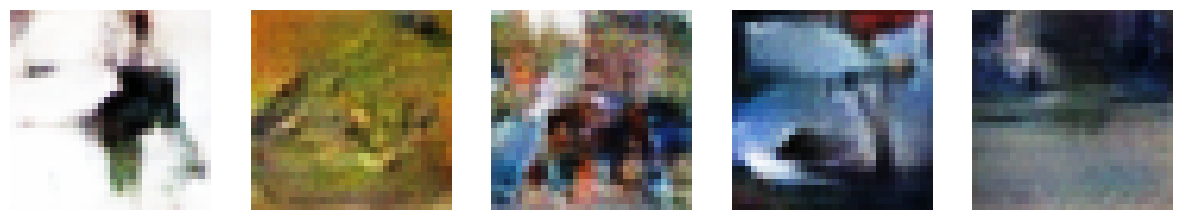

Epoch [90/100], KID: -154797.453125, SWD: 0.23778300359845161


Epoch 91/100: 100%|██████████| 782/782 [00:32<00:00, 24.14it/s]


d_loss: -1.645194411277771, g_loss: -4.184598922729492


Epoch 92/100: 100%|██████████| 782/782 [00:32<00:00, 24.40it/s]


d_loss: -2.1354575157165527, g_loss: -3.961298942565918


Epoch 93/100: 100%|██████████| 782/782 [00:31<00:00, 24.47it/s]


d_loss: -1.8009076118469238, g_loss: -3.6810197830200195


Epoch 94/100: 100%|██████████| 782/782 [00:32<00:00, 24.38it/s]


d_loss: -1.9462661743164062, g_loss: -4.100604057312012


Epoch 95/100: 100%|██████████| 782/782 [00:32<00:00, 24.36it/s]


d_loss: -1.5092028379440308, g_loss: -3.039736270904541


Epoch 96/100: 100%|██████████| 782/782 [00:32<00:00, 24.39it/s]


d_loss: -1.75165593624115, g_loss: -3.707859754562378


Epoch 97/100: 100%|██████████| 782/782 [00:32<00:00, 24.33it/s]


d_loss: -1.056908130645752, g_loss: -1.9454123973846436


Epoch 98/100: 100%|██████████| 782/782 [00:32<00:00, 24.37it/s]


d_loss: -1.9720218181610107, g_loss: -1.0064420700073242


Epoch 99/100: 100%|██████████| 782/782 [00:32<00:00, 24.42it/s]


d_loss: -1.487616777420044, g_loss: -4.12833309173584


Epoch 100/100: 100%|██████████| 782/782 [00:32<00:00, 24.34it/s]


d_loss: -2.369393825531006, g_loss: -2.5692806243896484


<Figure size 640x480 with 0 Axes>

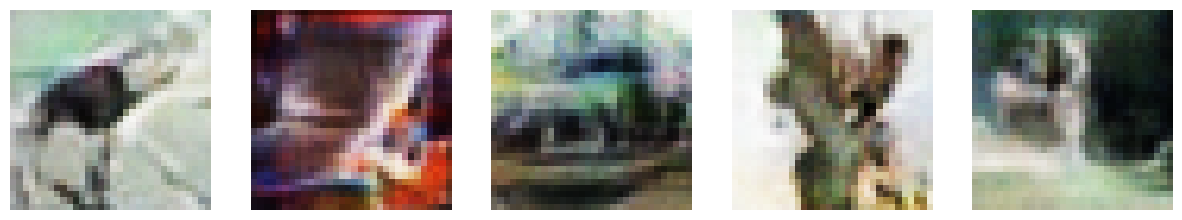

Epoch [100/100], KID: -152039.15625, SWD: 0.23101862333714962


<Figure size 640x480 with 0 Axes>

In [ ]:
import torch
from torch import nn, autograd
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('device = ', device)

# 定义模型超参数
latent_dim = 100
num_epochs = 100
batch_size = 64
learning_rate = 0.0002
lambda_gp = 10  # Gradient penalty lambda hyperparameter

# 加载数据集
transform = Compose([
    ToTensor(),
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_data = datasets.CIFAR10(
    root='.',
    train=True,
    download=True,
    transform=transform
)

test_data = datasets.CIFAR10(
    root='.',
    train=False,
    download=True,
    transform=transform
)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # 输入为100维的随机噪声向量
        self.fc = nn.Linear(100, 512*2*2) # 输出为512x2x2
        self.deconv1 = nn.ConvTranspose2d(512, 256, 4, 2, 1) # 输出为256x4x4
        self.deconv2 = nn.ConvTranspose2d(256, 128, 4, 2, 1) # 输出为128x8x8
        self.deconv3 = nn.ConvTranspose2d(128, 64, 4, 2, 1) # 输出为64x16x16
        self.deconv4 = nn.ConvTranspose2d(64, 3, 4, 2, 1) # 输出为3x32x32
        self.bn1 = nn.BatchNorm2d(256)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, z):
        z = self.fc(z)
        z = z.view(-1, 512, 2 ,2)
        z = self.relu(self.bn1(self.deconv1(z)))
        z = self.relu(self.bn2(self.deconv2(z)))
        z = self.relu(self.bn3(self.deconv3(z)))
        z = self.tanh(self.deconv4(z))
        return z

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # 输入为3x32x32的CIFAR-10图像
        self.conv1 = nn.Conv2d(3, 64, 4, 2, 1) # 输出为64x16x16
        self.conv2 = nn.Conv2d(64, 128, 4, 2, 1) # 输出为128x8x8
        self.conv3 = nn.Conv2d(128, 256, 4, 2, 1) # 输出为256x4x4
        self.conv4 = nn.Conv2d(256, 512, 4, 2, 1) # 输出为512x2x2
        self.fc = nn.Linear(512*2*2, 1) # 输出为1
        self.lrelu = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = self.lrelu(self.conv1(x))
        x = self.lrelu(self.conv2(x))
        x = self.lrelu(self.conv3(x))
        x = self.lrelu(self.conv4(x))
        x = x.view(-1, 512*2*2)
        x = self.fc(x)
        return x

G = Generator().to(device)
D = Discriminator().to(device)

d_optimizer = torch.optim.RMSprop(D.parameters(), lr=learning_rate)
g_optimizer = torch.optim.RMSprop(G.parameters(), lr=learning_rate)

def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

# 计算梯度惩罚
def compute_gradient_penalty(D, real_samples, fake_samples):
    alpha = torch.Tensor(np.random.random((real_samples.size(0), 1, 1, 1))).to(device)
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = torch.ones(real_samples.shape[0], 1).to(device)
    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

# 训练模型
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
        # 确保最后一批次的尺寸正确
        if images.shape[0] != batch_size:
            continue

        real_images = images.to(device)

        # 训练判别器
        z = torch.randn(batch_size, latent_dim).to(device)
        fake_images = G(z)
        
        real_outputs = D(real_images)
        fake_outputs = D(fake_images.detach())

        # 计算梯度惩罚
        gradient_penalty = compute_gradient_penalty(D, real_images.data, fake_images.data)

        d_loss = -torch.mean(real_outputs) + torch.mean(fake_outputs) + lambda_gp * gradient_penalty

        reset_grad()
        d_loss.backward()
        d_optimizer.step()

        # 训练生成器
        if i % 5 == 0:
            z = torch.randn(batch_size, latent_dim).to(device)
            fake_images = G(z)
            outputs = D(fake_images)
            g_loss = -torch.mean(outputs)

            reset_grad()
            g_loss.backward()
            g_optimizer.step()

    print(f"d_loss: {d_loss.item()}, g_loss: {g_loss.item()}")

    if (epoch + 1) % 10 == 0:
        # 每5个epoch结束后，随机展示5个生成的图像
        z = torch.randn(5, latent_dim).to(device)
        fake_images = G(z)
        fake_images = fake_images.view(-1, 3, 32, 32)
        fake_images = denorm(fake_images)

        fig, ax = plt.subplots(1, 5, figsize=(15, 3))
        for i, img in enumerate(fake_images.detach().cpu().numpy()):
            ax[i].imshow(np.transpose(img, (1, 2, 0)))
            ax[i].axis('off')
        plt.show()
        plt.savefig(f'WGAN-GP_[{epoch}].png')

        z = torch.randn(len(test_data), latent_dim).to(device)
        fake_images = G(z)
        fake_images = fake_images.view(-1, 3, 32, 32)
        fake_images = denorm(fake_images)

        # 创建生成的数据集对象
        generated_data = TensorDataset(fake_images.detach().cpu(), torch.zeros(len(fake_images)))

        # 创建KID和SWD对象并计算指标
        kid_calculator = KID(real_dataset=test_data, generated_dataset=generated_data)
        swd_calculator = SWD(real_dataset=test_data, generated_dataset=generated_data)
        kid_score = kid_calculator.compute_kid()
        swd_score = swd_calculator.compute_swd()

        # 在每个epoch结束后打印KID和SWD指标
        print(f"Epoch [{epoch+1}/{num_epochs}], KID: {kid_score}, SWD: {swd_score}")
